# 04a Rank CATE Estimators - Grid Search over (Q, k)

This notebook implements **Stage 2A** of the ESTIMATOR_RANKING_PLAN:

1. **Step 1**: Compute t-statistics for each (estimator, CV, fold, q) tuple
2. **Step 2**: Average t-statistics across quantiles in Q for each (estimator, CV)

**Grid Search Parameters:**
- Q ∈ {{0.1}, {0.1,0.2}, {0.1,0.2,0.3}, {0.1,0.2,0.3,0.4}, {0.1,0.2,0.3,0.4,0.5}}
- k ∈ {1, 2, ..., 10}

**Outputs:**
- Intermediate results: (estimator, cv, fold, q) → t_statistic
- Aggregated results: (estimator, cv, Q) → mean_t_statistic

In [1]:
from pathlib import Path

# Ensure output directories exist
OUTPUT_PATH = Path("output/analysis")
INTERMEDIATE_PATH = Path("output/intermediate/grid_search")
FIGURES_PATH = Path("output/figures")
for p in [OUTPUT_PATH, INTERMEDIATE_PATH, FIGURES_PATH]:
    p.mkdir(parents=True, exist_ok=True)

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import joblib
import warnings
warnings.filterwarnings("ignore")

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Custom methods
from methods.cate_estimator_validation import get_estimator_scores, aggregate_estimator_scores

Failed to import duecredit due to No module named 'duecredit'


## 1. Configuration

In [3]:
# Analysis configuration
OUTCOME_NAME = "fausebal"
DIR_NEG = False  # We want POSITIVE treatment effects (higher is better)

# Grid search parameters
Q_SETS = {
    "Q1": np.array([0.1]),
    "Q2": np.array([0.1, 0.2]),
    "Q3": np.array([0.1, 0.2, 0.3]),
    "Q4": np.array([0.1, 0.2, 0.3, 0.4]),
    "Q5": np.array([0.1, 0.2, 0.3, 0.4, 0.5]),
}

K_VALUES = list(range(1, 11))  # k ∈ {1, 2, ..., 10}

# All individual quantiles needed
ALL_Q_VALUES = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

print(f"Outcome: {OUTCOME_NAME}")
print(f"Direction: {'Negative' if DIR_NEG else 'Positive'} effects preferred")
print(f"Q sets: {list(Q_SETS.keys())}")
print(f"k values: {K_VALUES}")

Outcome: fausebal
Direction: Positive effects preferred
Q sets: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']
k values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## 2. Load Fitted Libraries

In [4]:
# Load fitted CATE estimator libraries
file_path = f"output/analysis/{OUTCOME_NAME}/{OUTCOME_NAME}_fitted_libraries.pkl"
fitted_libraries = joblib.load(file_path)

print(f"Loaded fitted libraries from {file_path}")
print(f"Perturbations: {list(fitted_libraries.keys())}")
print(f"Estimators: {list(fitted_libraries['pert_none'].keys())}")

Loaded fitted libraries from output/analysis/fausebal/fausebal_fitted_libraries.pkl
Perturbations: ['pert_none', 'pert_cv_0', 'pert_cv_1']
Estimators: ['s_xgb', 's_rf', 't_lasso', 't_logistic', 't_rf', 't_xgb', 'x_lasso', 'x_logistic', 'x_rf', 'x_xgb', 'r_lassolasso', 'r_lassoxgb', 'r_lassorf', 'r_rflasso', 'r_rfrf', 'r_rfxgb', 'r_xgblasso', 'r_xgbrf', 'r_xgbxgb', 'causal_tree_1', 'causal_tree_2', 'causal_forest_1', 'causal_forest_2']


## 3. Step 1: Compute t-Statistics Per Quantile

For each (estimator, CV, fold, q), compute the t-statistic for the top q-quantile subgroup.

In [5]:
# Compute t-statistics for all quantiles
# This gives us a DataFrame with columns like: pert=none/q=0.1/fold=0, etc.
print("Computing t-statistics for all (estimator, CV, fold, q) combinations...")
scores_df = get_estimator_scores(fitted_libraries, ALL_Q_VALUES, dir_neg=DIR_NEG, kind="val")

# Save intermediate results
scores_df.to_csv(INTERMEDIATE_PATH / f"{OUTCOME_NAME}_all_t_statistics.csv")
print(f"Saved to {INTERMEDIATE_PATH / f'{OUTCOME_NAME}_all_t_statistics.csv'}")

print(f"\nShape: {scores_df.shape}")
print(f"Columns sample: {list(scores_df.columns[:5])}")
scores_df.head()

Computing t-statistics for all (estimator, CV, fold, q) combinations...
Saved to output/intermediate/grid_search/fausebal_all_t_statistics.csv

Shape: (23, 60)
Columns sample: ['pert=none/q=0.1/fold=0', 'pert=none/q=0.2/fold=0', 'pert=none/q=0.3/fold=0', 'pert=none/q=0.4/fold=0', 'pert=none/q=0.5/fold=0']


,pert=none/q=0.1/fold=0,pert=none/q=0.2/fold=0,pert=none/q=0.3/fold=0,pert=none/q=0.4/fold=0,pert=none/q=0.5/fold=0,pert=none/q=0.1/fold=1,pert=none/q=0.2/fold=1,pert=none/q=0.3/fold=1,pert=none/q=0.4/fold=1,pert=none/q=0.5/fold=1,...,pert=cv_1/q=0.1/fold=2,pert=cv_1/q=0.2/fold=2,pert=cv_1/q=0.3/fold=2,pert=cv_1/q=0.4/fold=2,pert=cv_1/q=0.5/fold=2,pert=cv_1/q=0.1/fold=3,pert=cv_1/q=0.2/fold=3,pert=cv_1/q=0.3/fold=3,pert=cv_1/q=0.4/fold=3,pert=cv_1/q=0.5/fold=3
estimator,,,,,,,,,,,,,,,,,,,,,
s_xgb,-0.909753,-0.384277,-0.492056,-0.706503,-0.151344,-0.488742,0.492771,-0.078310,-0.768146,0.135983,...,0.652033,0.160081,0.300734,-0.340509,0.469410,-0.187677,-0.319679,-0.237679,-0.998970,-0.069426
s_rf,0.155784,0.338261,0.812877,0.540407,-0.282620,-0.790162,-1.056187,-1.056187,0.214008,-0.285053,...,0.793210,0.923930,0.923930,-0.286043,-0.524404,-0.517578,-1.302584,-1.153527,-0.747557,-0.079795
t_lasso,0.864585,0.419424,1.820429,0.786785,1.161620,0.448986,0.865240,1.921649,1.828377,1.028176,...,0.871596,0.768221,0.560512,0.519034,0.673925,2.021015,1.099182,1.764107,1.432184,1.416400
t_logistic,0.949237,0.099987,1.319809,0.906027,1.522052,0.859567,0.175116,0.702374,1.716241,1.152308,...,1.546841,1.406127,-0.049461,-0.218392,-0.530157,1.486724,0.507656,1.361722,1.141498,1.735464
t_rf,0.870058,1.035085,0.097087,1.157635,0.667114,0.155591,0.565219,0.502804,0.875893,0.149034,...,0.666420,0.307554,1.289704,0.348718,-0.108488,-1.383233,-0.614094,-0.669012,0.397946,0.726105


In [6]:
# Parse column structure
def parse_column(col):
    """Parse column name like 'pert=none/q=0.1/fold=0' into components."""
    parts = col.split("/")
    pert = parts[0].split("=")[1]
    q = float(parts[1].split("=")[1])
    fold = int(parts[2].split("=")[1])
    return pert, q, fold

# Create a structured view of the data
column_info = [parse_column(col) for col in scores_df.columns]
perturbations = sorted(set(c[0] for c in column_info))
q_values = sorted(set(c[1] for c in column_info))
folds = sorted(set(c[2] for c in column_info))

print(f"Perturbations: {perturbations}")
print(f"Q values: {q_values}")
print(f"Folds: {folds}")

Perturbations: ['cv_0', 'cv_1', 'none']
Q values: [0.1, 0.2, 0.3, 0.4, 0.5]
Folds: [0, 1, 2, 3]


## 4. Step 2: Average t-Statistics Over Q for Each (Estimator, CV)

For each Q set, compute the mean t-statistic across quantiles in Q.

In [7]:
def compute_t_cv_Q(scores_df, Q_set, Q_name):
    """
    Compute t_CV,Q for each estimator and CV split.
    
    Steps:
    1. For each fold: t_fold,Q = mean(T_q for q in Q)
    2. For each CV: t_CV,Q = mean(t_fold,Q across 4 folds)
    
    Returns DataFrame: (estimator, cv) -> mean_t_statistic
    """
    results = {}
    
    for pert in perturbations:
        # Get columns for this perturbation and Q set
        cols_for_pert = []
        for q in Q_set:
            for fold in folds:
                col = f"pert={pert}/q={q}/fold={fold}"
                if col in scores_df.columns:
                    cols_for_pert.append(col)
        
        if cols_for_pert:
            # Average across all q values and folds for this perturbation
            results[f"pert={pert}"] = scores_df[cols_for_pert].mean(axis=1)
    
    result_df = pd.DataFrame(results)
    result_df.index = scores_df.index
    return result_df

# Compute t_CV,Q for each Q set
t_cv_Q_results = {}
for Q_name, Q_set in Q_SETS.items():
    print(f"Computing t_CV,Q for {Q_name} = {Q_set}...")
    t_cv_Q_results[Q_name] = compute_t_cv_Q(scores_df, Q_set, Q_name)

# Save results
joblib.dump(t_cv_Q_results, INTERMEDIATE_PATH / f"{OUTCOME_NAME}_t_cv_Q_results.pkl")
print(f"\nSaved t_CV,Q results to {INTERMEDIATE_PATH / f'{OUTCOME_NAME}_t_cv_Q_results.pkl'}")

Computing t_CV,Q for Q1 = [0.1]...
Computing t_CV,Q for Q2 = [0.1 0.2]...
Computing t_CV,Q for Q3 = [0.1 0.2 0.3]...
Computing t_CV,Q for Q4 = [0.1 0.2 0.3 0.4]...
Computing t_CV,Q for Q5 = [0.1 0.2 0.3 0.4 0.5]...

Saved t_CV,Q results to output/intermediate/grid_search/fausebal_t_cv_Q_results.pkl


In [8]:
# Display t_CV,Q for Q5 (full set)
print("t_CV,Q for Q5 = {0.1, 0.2, 0.3, 0.4, 0.5}:")
t_cv_Q_results["Q5"].round(3)

t_CV,Q for Q5 = {0.1, 0.2, 0.3, 0.4, 0.5}:


,pert=cv_0,pert=cv_1,pert=none
estimator,,,
s_xgb,-0.179,-0.410,-0.204
s_rf,-0.539,-0.046,0.253
t_lasso,0.422,0.399,0.728
t_logistic,0.298,0.307,0.604
t_rf,0.591,-0.245,0.395
t_xgb,0.695,0.400,0.493
x_lasso,0.394,0.407,0.675
x_logistic,0.453,0.479,0.763
x_rf,0.537,0.286,0.782


## 5. Rank Estimators Within Each CV Per Q

For each (CV, Q), rank estimators by their mean t-statistic (higher = better rank).

In [9]:
def compute_rankings(t_cv_Q_df):
    """
    Rank estimators within each CV by t_CV,Q.
    Higher t-statistic = lower rank (rank 1 = best).
    """
    # Rank: ascending=False means higher values get lower (better) ranks
    ranking_df = t_cv_Q_df.rank(ascending=False)
    return ranking_df

# Compute rankings for each Q set
rankings = {}
for Q_name, t_cv_Q_df in t_cv_Q_results.items():
    rankings[Q_name] = compute_rankings(t_cv_Q_df)
    rankings[Q_name]["max_rank"] = rankings[Q_name].max(axis=1)  # Worst-case rank
    rankings[Q_name] = rankings[Q_name].sort_values("max_rank")

# Save rankings
joblib.dump(rankings, INTERMEDIATE_PATH / f"{OUTCOME_NAME}_rankings_by_Q.pkl")
print(f"Saved rankings to {INTERMEDIATE_PATH / f'{OUTCOME_NAME}_rankings_by_Q.pkl'}")

Saved rankings to output/intermediate/grid_search/fausebal_rankings_by_Q.pkl


In [10]:
# Display rankings for Q5
print("Rankings for Q5 (sorted by worst-case rank):")
print("Rank 1 = Highest t-statistic, 23 = Lowest")
rankings["Q5"].head(15).round(1)

Rankings for Q5 (sorted by worst-case rank):
Rank 1 = Highest t-statistic, 23 = Lowest


,pert=cv_0,pert=cv_1,pert=none,max_rank
estimator,,,,
r_rflasso,1.0,1.0,2.0,2.0
x_logistic,7.0,2.0,4.0,7.0
r_xgblasso,4.0,7.0,1.0,7.0
t_lasso,8.0,6.0,5.0,8.0
x_rf,5.0,9.0,3.0,9.0
t_xgb,2.0,5.0,10.0,10.0
x_lasso,10.0,4.0,7.0,10.0
r_lassolasso,11.0,3.0,6.0,11.0
t_logistic,12.0,8.0,9.0,12.0


## 6. Select Ensembles via Intersection Criterion

For each (Q, k), find estimators that appear in top-k for **ALL THREE CVs**.

In [11]:
def select_ensemble(ranking_df, k):
    """
    Select estimators whose rank <= k in ALL perturbations.
    This is the StaDISC worst-case criterion.
    """
    pert_cols = [c for c in ranking_df.columns if c.startswith("pert=")]
    
    # Check if rank <= k for all perturbations
    passes_all = (ranking_df[pert_cols] <= k).all(axis=1)
    selected = ranking_df[passes_all].index.tolist()
    
    return selected

# Build ensemble table: (Q, k) -> [estimator list]
ensemble_table = {}
for Q_name in Q_SETS.keys():
    ensemble_table[Q_name] = {}
    for k in K_VALUES:
        ensemble = select_ensemble(rankings[Q_name], k)
        ensemble_table[Q_name][k] = ensemble

# Save ensemble table
joblib.dump(ensemble_table, INTERMEDIATE_PATH / f"{OUTCOME_NAME}_ensemble_table.pkl")
print(f"Saved ensemble table to {INTERMEDIATE_PATH / f'{OUTCOME_NAME}_ensemble_table.pkl'}")

Saved ensemble table to output/intermediate/grid_search/fausebal_ensemble_table.pkl


In [12]:
# Display ensemble table
print("Ensemble Table: (Q, k) -> Number of estimators passing worst-case criterion")
print("="*70)

summary_data = []
for Q_name in Q_SETS.keys():
    row = {"Q": Q_name}
    for k in K_VALUES:
        row[f"k={k}"] = len(ensemble_table[Q_name][k])
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data).set_index("Q")
print(summary_df)

Ensemble Table: (Q, k) -> Number of estimators passing worst-case criterion
    k=1  k=2  k=3  k=4  k=5  k=6  k=7  k=8  k=9  k=10
Q                                                    
Q1    0    0    0    0    2    2    5    8    8     8
Q2    0    0    0    0    0    2    4    6    6     6
Q3    0    1    1    1    1    1    2    3    4     6
Q4    0    0    0    1    1    1    1    3    5     7
Q5    0    1    1    1    1    1    3    4    5     7


## 7. Visualization: Rankings Across Perturbations

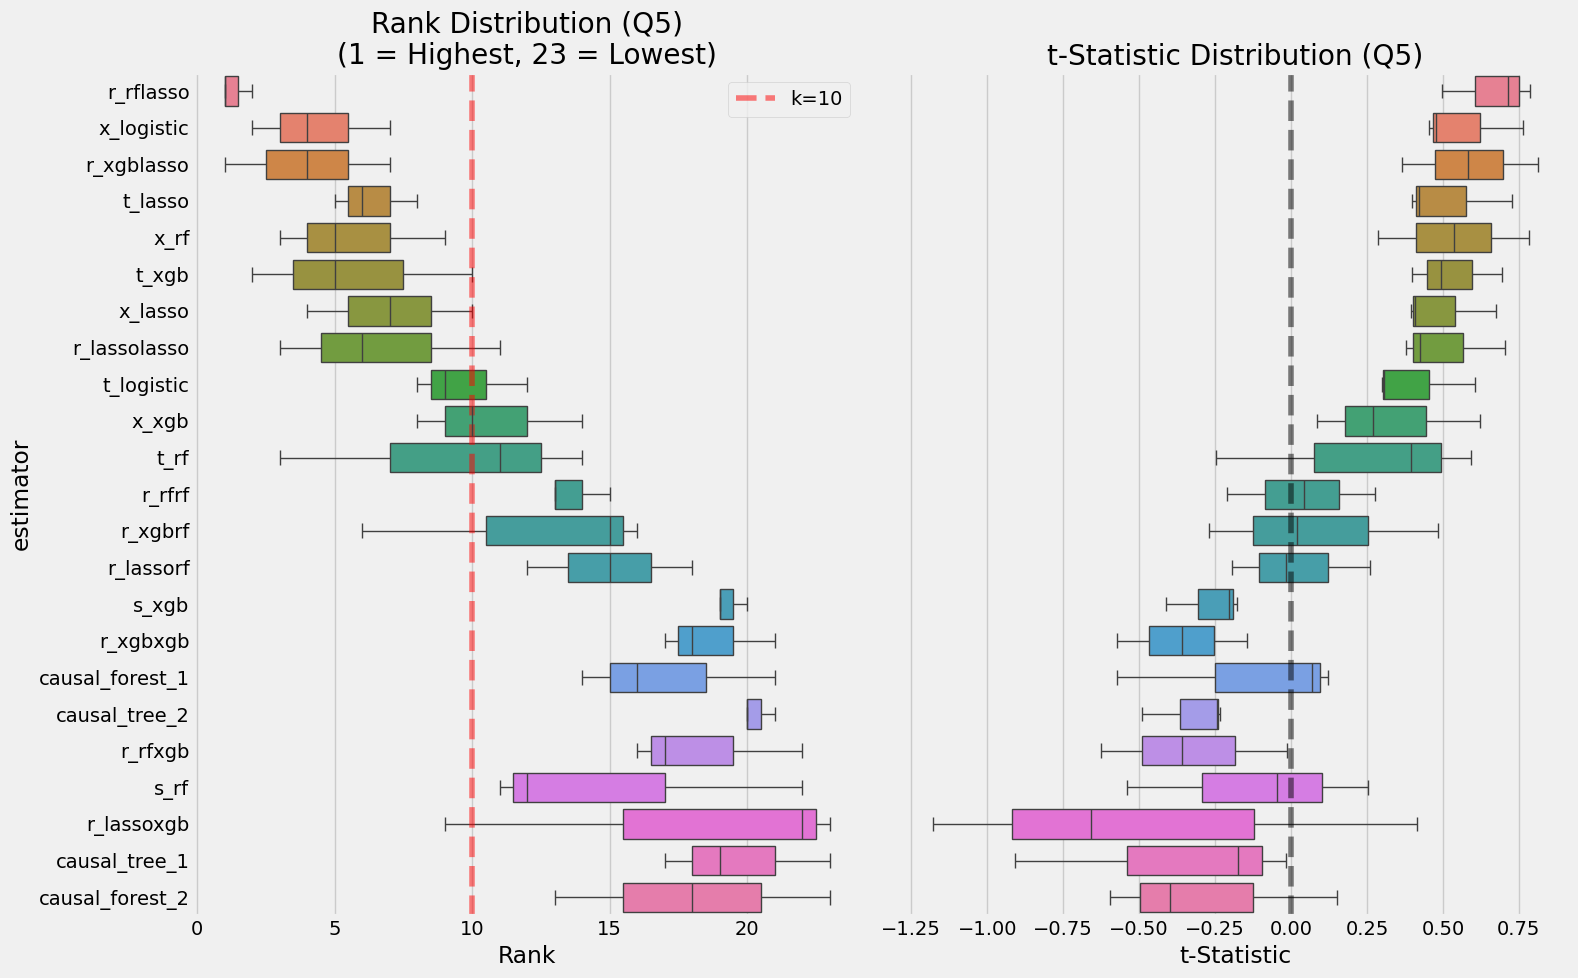

In [14]:
# Plot rankings for Q5
Q_name = "Q5"
ranking_df = rankings[Q_name].copy()
t_stat_df = t_cv_Q_results[Q_name].reindex(ranking_df.index)

fig, axes = plt.subplots(1, 2, figsize=(16, 10), sharey=True)

# Left: Ranks
ax = axes[0]
pert_cols = [c for c in ranking_df.columns if c.startswith("pert=")]
sns.boxplot(data=ranking_df[pert_cols].T, orient='h', ax=ax)
ax.set_title(f"Rank Distribution ({Q_name})\n(1 = Highest, 23 = Lowest)")
ax.set_xlabel("Rank")
ax.axvline(x=10, color='red', linestyle='--', alpha=0.5, label='k=10')
ax.legend()

# Right: t-statistics
ax = axes[1]
sns.boxplot(data=t_stat_df[pert_cols].T, orient='h', ax=ax)
ax.set_title(f"t-Statistic Distribution ({Q_name})")
ax.set_xlabel("t-Statistic")
ax.axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(FIGURES_PATH / f"{OUTCOME_NAME}_rankings_{Q_name}.png", dpi=150, bbox_inches='tight')
plt.show()

## 8. Summary

**Outputs saved:**
1. `{OUTCOME_NAME}_all_t_statistics.csv` - Per-fold t-statistics for each (estimator, CV, fold, q)
2. `{OUTCOME_NAME}_t_cv_Q_results.pkl` - Aggregated t_CV,Q for each (estimator, CV, Q)
3. `{OUTCOME_NAME}_rankings_by_Q.pkl` - Rankings within each CV for each Q
4. `{OUTCOME_NAME}_ensemble_table.pkl` - Ensembles passing worst-case criterion for each (Q, k)

**Next steps:**
- Notebook 04b: Validate ensembles with indicator B at q* = 0.9
- Notebook 04c: Select optimal (Q*, k*) configuration

In [15]:
# Final summary
print("="*70)
print("SUMMARY: Estimators Passing Worst-Case Criterion")
print("="*70)

# Find configurations with non-empty ensembles
passing_configs = []
for Q_name in Q_SETS.keys():
    for k in K_VALUES:
        if ensemble_table[Q_name][k]:
            passing_configs.append({
                "Q": Q_name,
                "k": k,
                "n_estimators": len(ensemble_table[Q_name][k]),
                "estimators": ensemble_table[Q_name][k]
            })

passing_df = pd.DataFrame(passing_configs)
print(f"\nTotal configurations with non-empty ensembles: {len(passing_configs)}")
print("\nFirst 20 configurations:")
print(passing_df.head(20).to_string(index=False))

SUMMARY: Estimators Passing Worst-Case Criterion

Total configurations with non-empty ensembles: 36

First 20 configurations:
 Q  k  n_estimators                                                                            estimators
Q1  5             2                                                                 [t_lasso, r_xgblasso]
Q1  6             2                                                                 [t_lasso, r_xgblasso]
Q1  7             5                            [t_lasso, r_xgblasso, r_rflasso, t_logistic, r_lassolasso]
Q1  8             8 [t_lasso, r_xgblasso, r_rflasso, t_logistic, r_lassolasso, x_rf, x_lasso, x_logistic]
Q1  9             8 [t_lasso, r_xgblasso, r_rflasso, t_logistic, r_lassolasso, x_rf, x_lasso, x_logistic]
Q1 10             8 [t_lasso, r_xgblasso, r_rflasso, t_logistic, r_lassolasso, x_rf, x_lasso, x_logistic]
Q2  6             2                                                                  [x_lasso, r_rflasso]
Q2  7             4       